In [39]:
study = 'Sleep Lab'

### DB and S3 ###

In [40]:
from aws_manager import S3Manager, DBManagerSystem
import yaml
import pandas as pd

def fetch_motion_results(db_manager, session_id):
    query = f"SELECT * FROM MotionResult WHERE SessionID = {session_id}"
    return pd.read_sql(query, db_manager.engine)

def fetch_study_sessions(db_manager, study):
    query = f"""
    SELECT Patient.PatientStudyName, Patient.EnrollmentTime,
    Session.* FROM Session 
    JOIN Patient ON Session.PatientID = Patient.ID 
    JOIN Study ON Patient.StudyID = Study.ID 
    WHERE Study.Name = '{study}'
    """
    return pd.read_sql(query, db_manager.engine)


def load_config():
    with open('params/parameters.yaml', 'r') as file:
        config = yaml.safe_load(file)
    return config

S3_CONFIG = load_config()['Cloud']['s3']
DB_CONFIG = load_config()['Cloud']['DB_system']

s3_manager = S3Manager(
    access_key_id=S3_CONFIG['access_key_id'],
    secret_access_key=S3_CONFIG['secret_access_key'],
    region=S3_CONFIG['region'],
    bucket_name=S3_CONFIG['bucket_name']
)

db_manager = DBManagerSystem(
    host=DB_CONFIG['host'],
    user=DB_CONFIG['user'],
    password=DB_CONFIG['password'],
    database=DB_CONFIG['database']
)

In [41]:
import numpy as np
session_df = fetch_study_sessions(db_manager, study)
session_df.head()

session_ids = session_df['ID'].tolist()
print(session_ids)
session_ids = [id for id in session_ids if id not in [375, 299]]
print(f"Sessions after removing 375: {session_ids}")


[299, 375, 379, 380, 381, 382, 384, 385, 386, 387, 388, 389, 390, 391, 392]
Sessions after removing 375: [379, 380, 381, 382, 384, 385, 386, 387, 388, 389, 390, 391, 392]


# Delay between signals #

In [100]:
import os
import os
import pandas as pd
import numpy as np
from mne.io import read_raw_edf

import sys
class SuppressPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

class SleepLabProcessor:
    def __init__(self, db_manager, s3_manager, edf_channel = 'Resp chest', static_detection = True, motion_label = 2, corr_th=0.8):
        self.db_manager = db_manager
        self.s3_manager = s3_manager
        self.local_path = 'data'
        self.static_detection = static_detection
        self.edf_channel = edf_channel
        self.fps = 200
        self.motion_label = motion_label # 1: mild, 2: strong, 3: sitting/standing
        self.window_minute = 2 # window size for chest signal
        self.correlation_threshold = corr_th
        if not os.path.exists(self.local_path):
            os.makedirs(self.local_path)

    def create_paths(self):
        self.session_local_path = f'{self.local_path}/{self.patient_name}_{self.session_date}'
        if not os.path.exists(self.session_local_path):
            os.makedirs(self.session_local_path)
        self.analysis_path = f'{self.session_local_path}/{self.edf_channel}'
        if not os.path.exists(self.analysis_path):
            os.makedirs(self.analysis_path)
            
    def process(self, session_id, num_samples):
        self.session_id = session_id
        self.fetch_patient_info()
        self.create_paths()

        print(f"\nPatient Name: {self.patient_name}, Session date: {self.session_date}, Session id: {self.session_id}, edf channel: {self.edf_channel}")
        
        print('Downloading EDF and labeling file...')
        edf_file_path = self.download_edf_file()
        labeling_path = self.download_labeling_file()
        
        print('Fetching chest channel...')
        chest_df = self.extract_chest_signal(edf_file_path)
        
        print('Fetching holosis motion results...')
        self.motion_results = self.fetch_motion_results()
        if self.motion_results.empty:
            print("No motion results found for this session")
            return None, None, None, None, None
        
        print('Choosing samples and downloading signals...')
        chosen_signals_df, signals = self.choose_samples_and_download_signals(self.motion_results, num_samples)

        print('Evaluating time delay...')
        signals, high_corr_chest_signals, chosen_signals_df, delays, correlations = self.compute_delays(signals, chosen_signals_df, chest_df)
        
        # Plot delays vs time for high correlation signals
        self.plot_delays(chosen_signals_df, correlations)
        
        valid_delays = [delay for delay, corr in zip(delays, correlations) if corr >= self.correlation_threshold]
        
        return chosen_signals_df, signals, high_corr_chest_signals, delays, valid_delays

    def plot_delays(self, chosen_signals_df, correlations):
        import matplotlib.pyplot as plt
        
        # Filter for signals with correlation above threshold
        high_corr_mask = correlations >= self.correlation_threshold
        filtered_df = chosen_signals_df[high_corr_mask].copy()
        
        if not filtered_df.empty:
            plt.figure(figsize=(10, 6))
            plt.scatter(filtered_df['sample_time'], filtered_df['delay_seconds'])
            plt.xlabel('Time')
            plt.ylabel('Delay (seconds)')
            plt.title(f'Delay vs Time (Correlation > {self.correlation_threshold})\n{self.patient_name} {self.session_date}')
            plt.grid(True)
            plt.xticks(rotation=45)
            # Set x-axis limits to session start and end times
            plt.xlim(self.session_start, self.session_end)
            # Set y-axis limits
            min_delay = min(-2, filtered_df['delay_seconds'].min())
            max_delay = max(2, filtered_df['delay_seconds'].max())
            plt.ylim(min_delay, max_delay)
            plt.tight_layout()
            plt.savefig(f'{self.analysis_path}/delays_vs_time.png')
            plt.close()
        else:
            print(f"No signals found with correlation above {self.correlation_threshold}")

    def plot_signals(self, signals, chosen_signals_df, high_corr_chest_signals):
        import matplotlib.pyplot as plt
        for index, row in chosen_signals_df.iterrows():
            radar_signal_id = row['session_signal_id']
            signal = signals[radar_signal_id]
            chest_signal = high_corr_chest_signals[radar_signal_id]
            delay_seconds = row['delay_seconds']
            timestamp = row['sample_time']
            # Create a new figure and axis
            fig, ax1 = plt.subplots()

            # Create time array in seconds
            time = np.arange(len(signal)) / self.fps

            # Plot the main signal
            ax1.set_xlabel('Time (s)')
            ax1.set_ylabel('Holosis signal', color='tab:blue')
            ax1.plot(time, signal, color='tab:blue', label='Signal')
            ax1.tick_params(axis='y', labelcolor='tab:blue')

            # Create a second y-axis for the chest signal
            ax2 = ax1.twinx()
            ax2.set_ylabel('Chest Signal', color='tab:red')
            ax2.plot(time, chest_signal, color='tab:red', label='Chest Signal')
            ax2.tick_params(axis='y', labelcolor='tab:red')

            # Add a title and save the plot
            plt.title(f'{self.patient_name} {self.session_date}\n'
                     f'holosis signal time = {timestamp}, delay = {round(delay_seconds,1)} seconds')
            fig.tight_layout()
            plt.savefig(f'{self.analysis_path}/signal_{radar_signal_id}.png')
            plt.close()


    def plot_analysis(self, radar_signal_id, signal, chest_df, best_chest_signal, corr_df, timestamp, delay_seconds):
        import matplotlib.pyplot as plt
        # Create time arrays
        time_signal = np.arange(len(signal)) / self.fps
        time_correlation = corr_df['time']
        correlation = corr_df['correlation']
        timestamp = pd.Timestamp(timestamp)
        time_diff_seconds = (time_correlation - timestamp).dt.total_seconds()
        
        max_correlation = correlation.max()
        title_color = 'red' if max_correlation < self.correlation_threshold else 'green'
                
        # Plotting
        fig, axs = plt.subplots(3, 1, figsize=(10, 12))
        
        # 1. Correlation vs Time
        axs[0].plot(time_diff_seconds, correlation)
        # Add vertical line at chosen delay point
        axs[0].axvline(x=-delay_seconds, color='g', linestyle='--', label='Chosen signal')
        title = f'Correlation vs Time delay, holosis signal time = {timestamp}'
        axs[0].set_title(title, color=title_color)
        axs[0].set_xlabel('Time delay(s)')
        axs[0].set_ylabel('Correlation')
        axs[0].set_ylim(0, 1)
        axs[0].legend()
        
        # 2. Same Time Signal vs Our Signal
        start_index = np.argmin(np.abs(chest_df['Timestamp'] - timestamp))
        end_index = start_index + len(signal)
        if end_index > len(chest_df):
            end_index = len(chest_df)
            print(f"Warning: Signal {radar_signal_id} is longer than chest signal. Truncating signal.")
            
        chest_signal = chest_df[self.edf_channel].values[start_index:end_index]
        chest_time = np.arange(len(chest_signal)) / self.fps

        # Create twin axis for chest signal
        ax1 = axs[1]
        ax2 = ax1.twinx()
        # Plot signals on separate y-axes
        ax1.plot(time_signal, signal, color='tab:blue', label='Our Signal')
        ax1.set_ylabel('Our Signal', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax2.plot(chest_time, chest_signal, color='tab:red', label='Chest Signal') 
        ax2.set_ylabel('Chest Signal', color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')
        title = 'Same Time Chest Signal vs Our Signal'
        ax1.set_title(title, color=title_color)
        ax1.set_xlabel('Time (s)')
        # Add legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2)
        
        # 3. Best Signal According to Correlation vs Our Signal
        ax1 = axs[2]
        ax2 = ax1.twinx()
        ax1.plot(time_signal, signal, color='tab:blue', label='Our Signal')
        ax1.set_ylabel('Our Signal', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax2.plot(time_signal, best_chest_signal, color='tab:red', label='Best Chest Signal')
        ax2.set_ylabel('Chest Signal', color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')
        title = f'Best Signal According to Correlation vs Our Signal\nTime delay = {-round(delay_seconds,1)} seconds'
        ax1.set_title(title, color=title_color)
        ax1.set_xlabel('Time (s)')
        
        # Add legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2)
        # Adjust layout and save
        plt.tight_layout()
        plots_folder = f'{self.analysis_path}/correlation_plots'
        if not os.path.exists(plots_folder):
            os.makedirs(plots_folder)
        plt.savefig(f'{plots_folder}/signal_{radar_signal_id}.png')
        plt.close()
    
    def compute_delays(self, signals, chosen_signals_df, chest_df):
        # Convert timestamps to datetime
        chest_df['Timestamp'] = pd.to_datetime(chest_df['Timestamp'])
        chest_resampled = chest_df.copy()
        high_corr_chest_signals = {}
        delays = []
        correlations = []
        
        # Iterate over each signal
        for index, row in chosen_signals_df.iterrows():
            radar_signal_id = row['session_signal_id']
            signal = signals[radar_signal_id]
            timestamp = row['sample_time']
            
            # Extract window
            window_start = timestamp - pd.Timedelta(minutes=self.window_minute) 
            window_end = timestamp + pd.Timedelta(minutes=self.window_minute) + pd.Timedelta(seconds= len(signal)/self.fps)
            chest_window = chest_resampled[(chest_resampled['Timestamp'] >= window_start) & 
                                           (chest_resampled['Timestamp'] <= window_end)]
            
            # Compute cross-correlation
            if not chest_window.empty:
                delay_seconds, best_chest_signal, corr_df, max_corr = self.eval_cross_corr(signal, chest_window, timestamp)
                max_correlation = corr_df['correlation'].max()
                correlations.append(max_correlation)
                self.plot_analysis(radar_signal_id, signal, chest_df, best_chest_signal, corr_df, timestamp, delay_seconds)
                delays.append(delay_seconds)
                high_corr_chest_signals[radar_signal_id] = best_chest_signal
                chosen_signals_df.loc[index, 'delay_seconds'] = delay_seconds
                chosen_signals_df.loc[index, 'max_corr'] = max_corr
            else:
                signals.pop(radar_signal_id)
                chosen_signals_df = chosen_signals_df[chosen_signals_df['session_signal_id'] != radar_signal_id]
                print(f"No chest data found for signal {radar_signal_id}")
            
        chosen_signals_df.to_csv(f'{self.analysis_path}/delay.csv', index=False)
        return signals, high_corr_chest_signals, chosen_signals_df, delays, np.array(correlations)

    def eval_cross_corr(self, signal, chest_window, signal_time):
        from scipy.signal import correlate
        chest_signal = chest_window[self.edf_channel].values
        chest_signal = chest_signal - np.mean(chest_signal)
        signal = signal - np.mean(signal)
        
        # Correlation
        correlation = correlate(signal, chest_signal, mode='valid')
        
        # Pearson correlation
        signal_std = np.std(signal)
        chest_signal_std = np.std(chest_signal)
        correlation = correlation / (len(signal) * signal_std * chest_signal_std)
        correlation = (correlation + 1) / 2
        
        corr_chest_time = chest_window['Timestamp'].values[len(chest_signal) - np.arange(len(correlation)) - len(signal)]
        corr_df = pd.DataFrame({'correlation': correlation, 'time': corr_chest_time})
        
        # Find the time point closest to zero delay
        zero_delay_idx = len(correlation) // 2
        
        # Define the interval of ±5 seconds around zero delay (10 seconds total)
        interval_samples = int(5 * self.fps)  # 5 seconds * samples per second
        start_idx = max(0, zero_delay_idx - interval_samples)
        end_idx = min(len(correlation), zero_delay_idx + interval_samples)
        
        # Find the maximum correlation within this interval
        interval_correlation = correlation[start_idx:end_idx]
        max_corr_idx = start_idx + np.argmax(interval_correlation)
        max_corr = interval_correlation.max()
        # Calculate the corresponding index in the chest signal
        max_ind = len(chest_signal) - max_corr_idx - len(signal)
        
        chest_time = chest_window['Timestamp'].iloc[max_ind]
        delay_seconds = (signal_time - chest_time).total_seconds()
        chest_corr_signal = chest_signal[max_ind:max_ind+len(signal)]
        
        return delay_seconds, chest_corr_signal, corr_df, max_corr

    def fetch_patient_info(self):
        query = f"""
        SELECT Patient.ID, Patient.PatientStudyName, Session.StartTime, Session.EndTime FROM Session 
        JOIN Patient ON Session.PatientID = Patient.ID
        WHERE Session.ID = {self.session_id}
        """
        result = pd.read_sql(query, self.db_manager.engine)
        if not result.empty:
            self.patient_id = result.iloc[0]['ID']
            self.patient_name = result.iloc[0]['PatientStudyName']
            self.session_date = pd.to_datetime(result.iloc[0]['StartTime']).date().strftime('%Y%m%d')
            self.session_start = pd.to_datetime(result.iloc[0]['StartTime'])
            self.session_end = pd.to_datetime(result.iloc[0]['EndTime'])
        else:
            raise ValueError("Session ID not found")

    def download_edf_file(self):
        self.patient_number = self.patient_name.replace('SL', '')
        edf_sesison_name = f"{self.session_date}-{self.patient_number}"
        self.edf_local = f"{self.session_local_path}/{edf_sesison_name}.edf"
        self.edf_s3 = f"{self.s3_manager.bucket}/edf_files/{edf_sesison_name}/{edf_sesison_name}.edf"
        # print(f"edf s3 path: {self.edf_s3}")
        # print(f"edf local path: {self.edf_local}")
        self.s3_manager.download_from_s3(self.edf_s3, self.edf_local)
        return self.edf_local
    
    def download_labeling_file(self):
        self.patient_number = self.patient_name.replace('SL', '')
        sesison_name = f"{self.session_date}-{self.patient_number}"
        self.labeling_local = f"{self.session_local_path}/{sesison_name}"
        self.labeling_s3 = f"{self.s3_manager.bucket}/edf_files/{sesison_name}/{sesison_name}"
        self.s3_manager.download_from_s3(self.labeling_s3, self.labeling_local)
        return self.labeling_local
    
    def extract_chest_signal(self, file_path):
        from datetime import timedelta
        with SuppressPrints():
            raw = read_raw_edf(file_path, preload=True)        # print("Channels:", raw.ch_names)
        if self.edf_channel in raw.ch_names:
            chest_data = raw.get_data(picks=self.edf_channel)
            relative_times = raw.times
            
            # Get measurement start time from the EDF file
            meas_date = raw.info['meas_date']
            if meas_date is not None:
                # Convert relative times to absolute timestamps
                absolute_times = [meas_date + timedelta(seconds=t) for t in relative_times]
                timestamps = [t.strftime('%Y-%m-%d %H:%M:%S.%f') for t in absolute_times]
            else:
                print("Warning: No measurement date found in EDF file")
                timestamps = relative_times
            
            # Save chest signal with timestamps
            chest_df = pd.DataFrame({'Timestamp': timestamps, self.edf_channel: chest_data[0]})
            chest_df.to_csv(f'{self.analysis_path}/chest_data.csv', index=False)
        else:
            print("Chest channel not found.")
        return chest_df

    def fetch_motion_results(self):
        query = f"""
        SELECT MotionResults.*, 
               RadarSignal.SignalS3Path,
               RadarSignal.StartTime,
               RadarSignal.EndTime
        FROM MotionResults 
        JOIN RadarSignal ON MotionResults.SessionSignalID = RadarSignal.SessionSignalID
        AND RadarSignal.SessionID = MotionResults.SessionID
        WHERE MotionResults.SessionID = {self.session_id}
        """
        return pd.read_sql(query, self.db_manager.engine)
    
    def fetch_resp_signals(self):
        query = f"""
        SELECT RadarSignal.* FROM RadarSignal
        WHERE RadarSignal.SessionID = {self.session_id}
        AND RadarSignal.RadarModeID = 3
        """
        return pd.read_sql(query, self.db_manager.engine)
    
    def choose_samples_and_download_signals(self, motion_results, num_samples):
        import warnings
        warnings.filterwarnings("ignore", category=FutureWarning, message="Series.__getitem__ treating keys as positions is deprecated")
        chosen_signals_df = pd.DataFrame(columns=['sample_time', 'session_signal_id', 'signal_s3_path', 'signal_local_path'])
        
        session_start = motion_results['StartTime'].min()
        session_end = motion_results['EndTime'].max()
        session_duration = (session_end - session_start).total_seconds()
        
        sample_times = [session_start + pd.Timedelta(seconds=x) for x in np.linspace(0, session_duration, num_samples)]
        
        # Create empty lists to store signal information
        chosen_signals = {
            'sample_time': [],
            'session_signal_id': [],
            'signal_s3_path': [],
            'signal_local_path': []
        }
        
        # First collect all signal information
        for time in sample_times:
            if self.static_detection:
                # get all signals that are fully static
                df_signals = self.fetch_resp_signals()
                relevant_results = df_signals[~df_signals['SessionSignalID'].isin(motion_results['SessionSignalID'])]
            else:
                # get all the signal that has the chosen motion label and take first record for each SessionSignalID
                relevant_results = motion_results[motion_results['MotionClassifierLabelID'] == self.motion_label].drop_duplicates('SessionSignalID', keep='first')
                
            closest_signal = relevant_results.iloc[(relevant_results['StartTime'] - time).abs().argsort()[:1]]
            
            radar_signal_id = closest_signal['SessionSignalID'].iloc[0].item()
            if radar_signal_id in chosen_signals_df['session_signal_id'].to_list():
                continue
            signal_time = closest_signal['StartTime'].iloc[0]
            radar_signal_s3_path = closest_signal['SignalS3Path'].iloc[0]
            radar_signal_local_path = f'{self.session_local_path}/Signals/{radar_signal_s3_path.split("/")[-1]}'
            
            # Store signal information
            chosen_signals['sample_time'].append(signal_time)
            chosen_signals['session_signal_id'].append(radar_signal_id)
            chosen_signals['signal_s3_path'].append(radar_signal_s3_path)
            chosen_signals['signal_local_path'].append(radar_signal_local_path)
            chosen_signals_df = pd.DataFrame(chosen_signals)
    
        # Download signals in parallel using threads
        from concurrent.futures import ThreadPoolExecutor
        
        def download_signal(s3_path, local_path):
            self.s3_manager.download_from_s3(s3_path, local_path)
            
        with ThreadPoolExecutor(max_workers=min(10, len(sample_times))) as executor:
            futures = []
            for s3_path, local_path in zip(chosen_signals['signal_s3_path'], chosen_signals['signal_local_path']):
                futures.append(executor.submit(download_signal, s3_path, local_path))
            
            # Wait for all downloads to complete
            for future in futures:
                future.result()
            
        # Create DataFrame with signal information
        chosen_signals_df = pd.DataFrame(chosen_signals)
        signals = {}
        for _, row in chosen_signals_df.iterrows():
            signal = np.load(row['signal_local_path'])
            sig_pp = signal - np.mean(signal, axis=0)
            max_ind = np.argmax(np.std(sig_pp, axis=0))
            resp_signal = sig_pp[:, max_ind]
            signals[row['session_signal_id']] = resp_signal
            
        return chosen_signals_df, signals

In [ ]:
num_samples = 100
summary_data = []
edf_channels = ['Resp chest', 'Resp abdomen']

for session_id in session_ids:
    if session_id>389:
        continue
    session_summary = {'Patient': None, 'Session date': None, 'SessionID': session_id}
    for edf_channel in edf_channels:
        processor = SleepLabProcessor(db_manager=db_manager, s3_manager=s3_manager, edf_channel=edf_channel, corr_th = 0.85)
        chosen_signals_df, signals, high_corr_chest_signals, delays, valid_delays = processor.process(session_id, num_samples)
        if chosen_signals_df is not None:
            session_summary[f'{edf_channel}_abs_median_delay'] = np.median(np.abs(valid_delays))
            
            # Update patient info after first processor run
            if session_summary['Patient'] is None:
                session_summary['Patient'] = processor.patient_name
                session_summary['Session date'] = processor.session_date
            
    summary_data.append(session_summary)



In [152]:
# Create summary DataFrame
summary_df = pd.DataFrame(summary_data)

# Round the values to 2 decimal places
summary_df = summary_df.round(2)

summary_df.to_csv('data/results_summary.csv', index=False)


In [95]:
import os
import glob

# Path to the data folder
data_folder = 'data'

# Find all .png files in the data folder and its subdirectories
png_files = glob.glob(os.path.join(data_folder, '**', '*.png'), recursive=True)

# Delete each file
for file in png_files:
    os.remove(file)
    # print(f"Deleted: {file}")

# RR and HR detetction rates #


In [38]:
from holosissystem.processing import RespirationProcessing, HeartRateProcessingNew
from holosissystem.analysis import RespirationAnalysis, HeartRateAnalysisNew, HeartRateAnalysisOptimized
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import numpy as np
import threading
import warnings
import os

# Suppress specific numpy warnings
warnings.filterwarnings('ignore', message='divide by zero encountered in log10')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='Mean of empty slice')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered in scalar divide')

def respiration_hr_processing(signal, session_signal_id, processors):
    # Process respiration signal
    resp_mscan_processed = processors['resp_processor'].preprocess_full_signal(signal)
    resp_detected, inhale_time, exhale_time, stop_time, resp_rate, _, _ = processors['resp_analyzer'].analyze_respiration_signal(resp_mscan_processed)

    if resp_detected:
        # Process heart rate signal
        hr_scan_processed = processors['hr_processor'].preprocess_signal(signal)
        # hr_scan_processed = hr_scan_processed[:-1,:]
        hr_estimate, hr_detected, _ = processors['hr_analyzer'].analyze_signal(hr_scan_processed, resp_rate)
    else:
        hr_estimate = None
        hr_detected = False

    resp_rate = round(resp_rate, 3) if resp_rate else None
    hr_estimate = round(hr_estimate, 3) if hr_estimate else None
    results = {
        'SessionSignalID': session_signal_id, 
        'RespDetected_new': bool(resp_detected), 
        'InhaleTime_new': inhale_time, 
        'ExhaleTime_new': exhale_time,
        'StopTime_new': stop_time, 
        'RespirationRate_new': resp_rate,
        'HrDetected_new': hr_detected, 
        'HeartRate_new': hr_estimate, 
        'MotionDetected_new': False,
        'MotionStartIndex_new': None, 
        'MotionEndIndex_new': None
    }
    return pd.DataFrame([results])

def fetch_resp_results(db_manager, session_id):
    query = f"""
    SELECT RespirationHrResults.*, Session.StartTime, Patient.PatientStudyName, RadarSignal.SignalS3Path
    FROM RespirationHrResults 
    JOIN RadarSignal ON RespirationHrResults.SessionSignalID = RadarSignal.SessionSignalID
    AND RespirationHrResults.SessionID = RadarSignal.SessionID
    JOIN Session ON RespirationHrResults.SessionID = Session.ID
    JOIN Patient ON Session.PatientID = Patient.ID
    WHERE RespirationHrResults.SessionID = {session_id}
    """
    return pd.read_sql(query, db_manager.engine)

def download_signal(s3_path, local_path):
    s3_manager.download_from_s3(s3_path, local_path)
            
def download_signals(df_resp):
    session_date = df_resp['StartTime'].min().date().strftime('%Y%m%d')
    patient_name = df_resp['PatientStudyName'].iloc[0]
    local_path = f"data/{patient_name}_{session_date}/signals"
    df_resp['LocalPath'] = df_resp['SignalS3Path'].apply(lambda x: f"{local_path}/{x.split('/')[-1]}")
    
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = []
        for s3_path, local_path in zip(df_resp['SignalS3Path'], df_resp['LocalPath']):
            futures.append(executor.submit(download_signal, s3_path, local_path))
        
        # Wait for all downloads to complete
        for future in futures:
            future.result()
    return df_resp

def process_signal(row, results_file_path, lock, processors):
    try:
        session_signal_id = row['SessionSignalID']
        signal_local_path = row['LocalPath']
        signal = np.load(signal_local_path)
        new_results = respiration_hr_processing(signal, session_signal_id, processors)
        df_results_session = pd.merge(pd.DataFrame([row]), new_results, on='SessionSignalID', how='outer')
        
        with lock:
            # If file doesn't exist, write with header
            if not os.path.exists(results_file_path):
                df_results_session.to_csv(results_file_path, index=False)
            else:
                # Append without header
                df_results_session.to_csv(results_file_path, mode='a', header=False, index=False)
        
        return df_results_session
    except Exception as e:
        print(f"Error processing signal {session_signal_id}: {e}")
        return None

if __name__ == '__main__':
    df_results_all = pd.DataFrame()
    results_file_path = "data/new_resp_results.csv"
    lock = threading.Lock()
    
    for session_id in tqdm(session_ids, desc="Processing sessions"):
        # Initialize processors for this session
        processors = {
            'resp_processor': RespirationProcessing(),
            'resp_analyzer': RespirationAnalysis(),
            'hr_processor': HeartRateProcessingNew(),
            'hr_analyzer': HeartRateAnalysisOptimized()
        }
        
        df_resp = fetch_resp_results(db_manager, session_id)
        df_resp = download_signals(df_resp)
        
        with ThreadPoolExecutor(max_workers=10) as executor:
            futures = []
            for index, row in df_resp.iterrows():
                futures.append(executor.submit(process_signal, row, results_file_path, lock, processors))
            
            for future in tqdm(futures, desc=f"Processing signals for session {session_id}", total=len(df_resp)):
                future.result()


NameError: name 'session_ids' is not defined

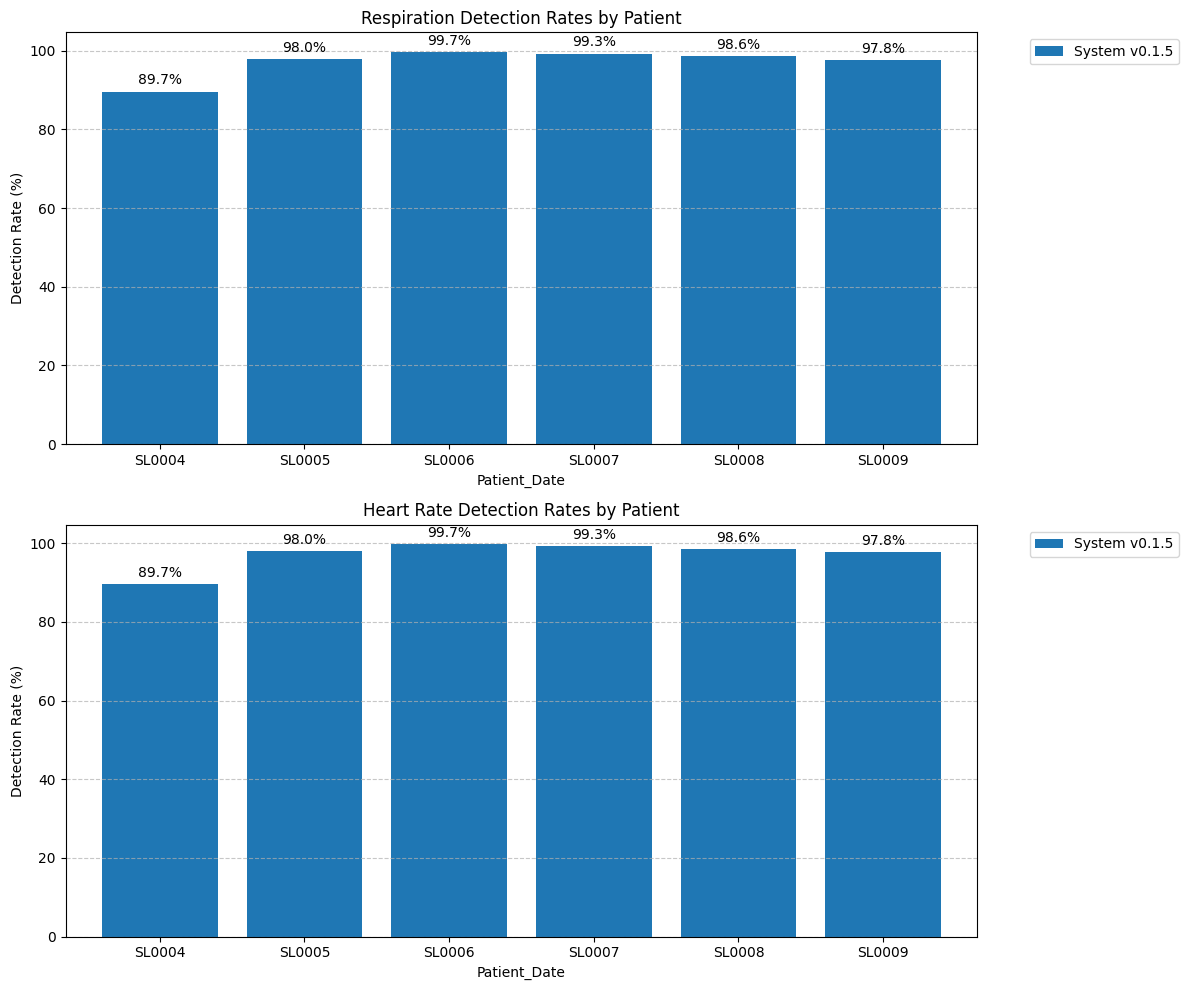


Detailed Detection Rates by Patient and Session (excluding specified patients):
Patient Session Date Patient_Date  System v0.1.1  System v0.1.5
 SL0004   2025-02-26       SL0004           45.2           89.7
 SL0005   2025-02-27       SL0005           46.5           98.0
 SL0006   2025-03-02       SL0006           88.1           99.7
 SL0007   2025-03-03       SL0007           75.2           99.3
 SL0008   2025-03-04       SL0008           69.4           98.6
 SL0009   2025-03-06       SL0009           64.0           97.8


In [45]:
import matplotlib.pyplot as plt

df_resp_new = pd.read_csv('data/new_resp_results.csv')
# Group by patient and session date, calculate detection rates
detection_rates = []
for (patient, start_time), group in df_resp_new.groupby(['PatientStudyName', pd.to_datetime(df_resp_new['StartTime']).dt.date]):
    rates = {
        'Patient': patient,
        'Session Date': start_time,
        'Patient_Date': f"{patient}\n{start_time}" if len(df_resp_new[df_resp_new['PatientStudyName'] == patient]['StartTime'].unique()) > 1 else patient,
        'System v0.1.1': (group['RespDetected'] == 1).mean() * 100,
        'System v0.1.5': (group['RespDetected_new'] == 1).mean() * 100,
        'System v0.1.1': (group['HrDetected'] == 1).mean() * 100,
        'System v0.1.5': (group['HrDetected_new'] == 1).mean() * 100
    }
    detection_rates.append(rates)

df_rates = pd.DataFrame(detection_rates)

def plot_detection_rates(df_rates, plot_old_version=True, exclude_patients=None):
    # Filter out excluded patients if specified
    if exclude_patients is not None:
        df_rates = df_rates[~df_rates['Patient'].isin(exclude_patients)].copy()
        
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Determine which columns to plot
    versions_to_plot = ['System v0.1.1', 'System v0.1.5'] if plot_old_version else ['System v0.1.5']
    
    # Plot Respiration Detection Rates
    df_rates.plot(x='Patient_Date', y=versions_to_plot, 
                  kind='bar', ax=ax1, width=0.8)
    ax1.set_title('Respiration Detection Rates by Patient')
    ax1.set_ylabel('Detection Rate (%)')
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    ax1.set_xticklabels(df_rates['Patient_Date'], rotation=0)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    for i in ax1.containers:
        ax1.bar_label(i, fmt='%.1f%%', padding=3)

    # Plot Heart Rate Detection Rates  
    df_rates.plot(x='Patient_Date', y=versions_to_plot,
                  kind='bar', ax=ax2, width=0.8)
    ax2.set_title('Heart Rate Detection Rates by Patient')
    ax2.set_ylabel('Detection Rate (%)')
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    ax2.set_xticklabels(df_rates['Patient_Date'], rotation=0)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    for i in ax2.containers:
        ax2.bar_label(i, fmt='%.1f%%', padding=3)

    plt.tight_layout()
    plt.show()

# Plot only new version excluding specified patients
patients_to_exclude = ['SL0010']  # Replace with actual patient IDs to exclude
plot_detection_rates(df_rates, plot_old_version=False, exclude_patients=patients_to_exclude)


# RR and HR accuracy #


In [ ]:
edf_file = 'data/SL0004_20250226/20250226-0004.edf'
raw = read_raw_edf(edf_file, preload=True)


### Plot reference signals and save them ###

Processing folders:   0%|          | 0/15 [00:00<?, ?it/s]

Extracting EDF parameters from /Users/yaelalon/SleepLabProcessing/data/SL0010_20250309/20250309-0010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6579399  =      0.000 ... 32896.995 secs...


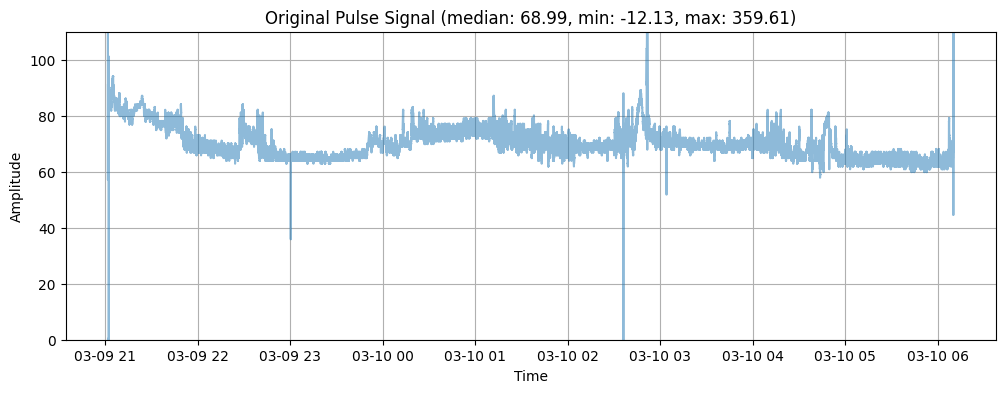

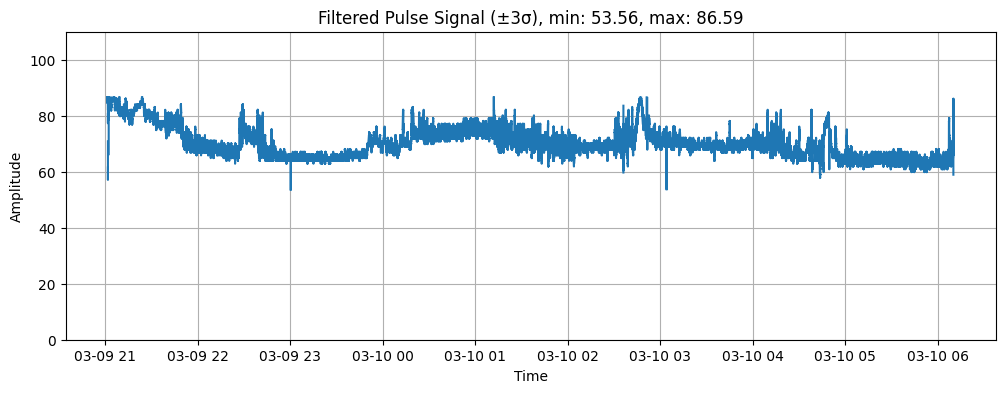

Data saved to: data/SL0010_20250309/pulse_data.csv
Removed 49940 points as outliers (0.76%)


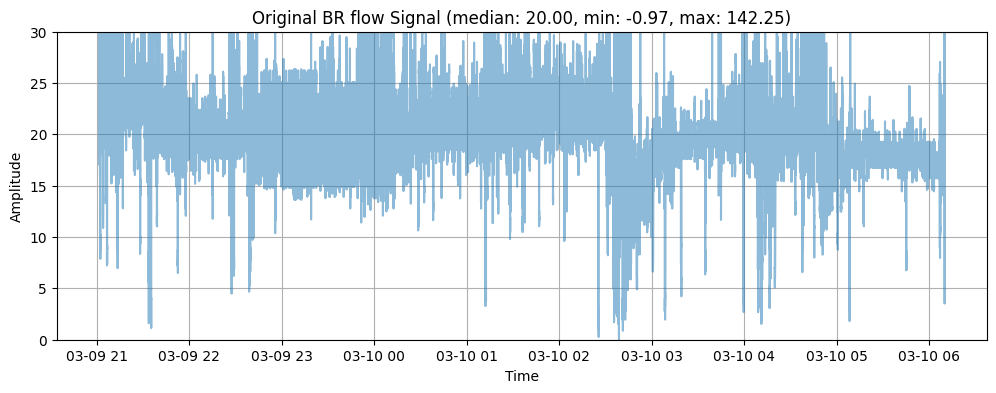

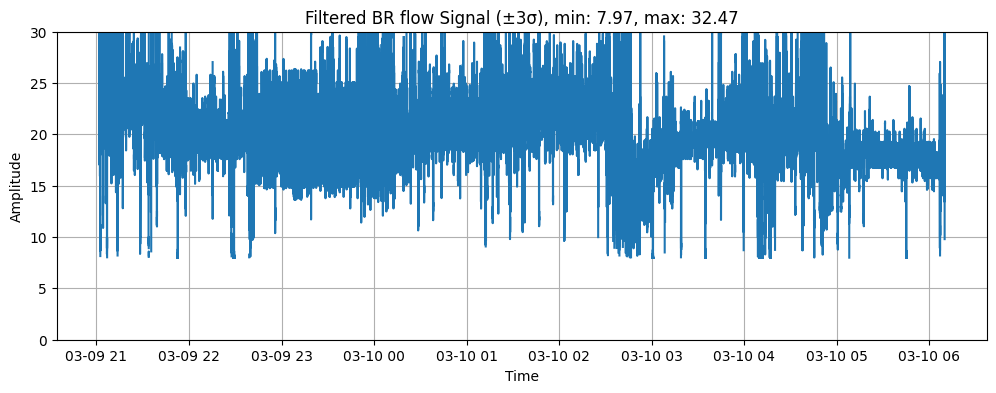

Processing folders:  20%|██        | 3/15 [02:14<08:56, 44.71s/it]

Data saved to: data/SL0010_20250309/br_flow_data.csv
Removed 119240 points as outliers (1.81%)
Extracting EDF parameters from /Users/yaelalon/SleepLabProcessing/data/SL0010_20250308/20250308-0010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5581199  =      0.000 ... 27905.995 secs...


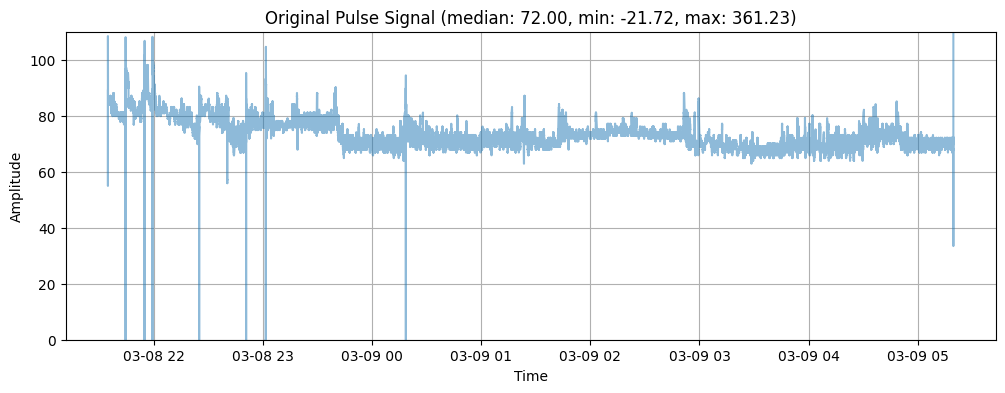

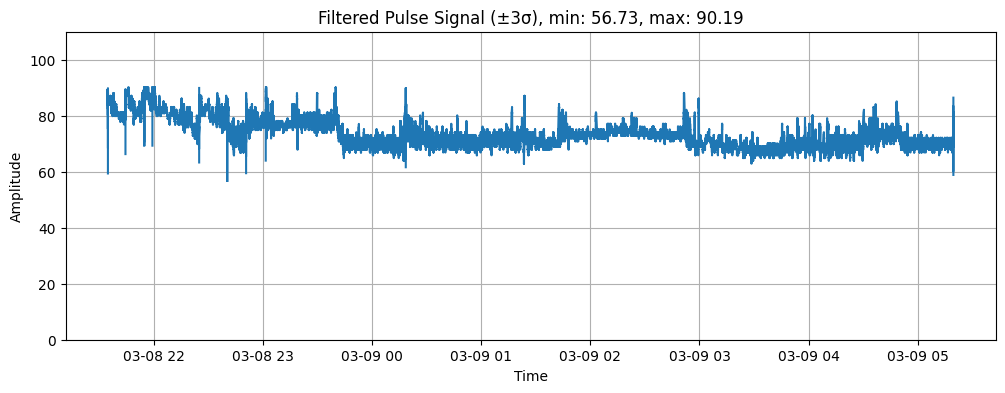

Data saved to: data/SL0010_20250308/pulse_data.csv
Removed 54742 points as outliers (0.98%)


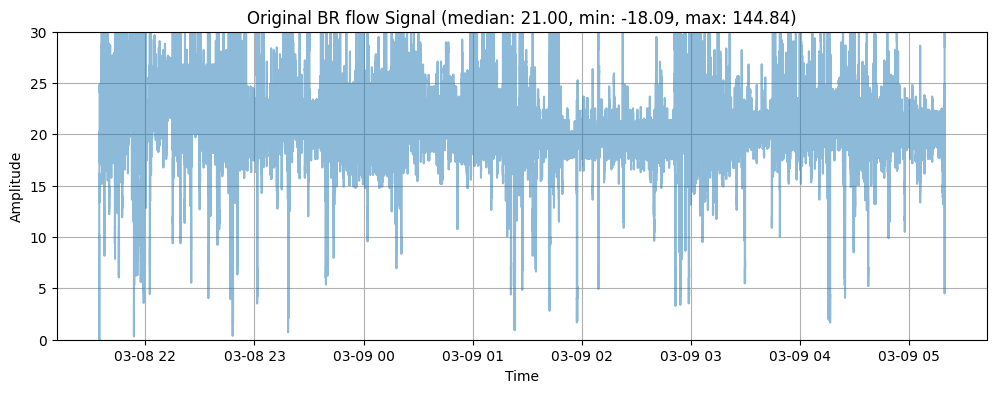

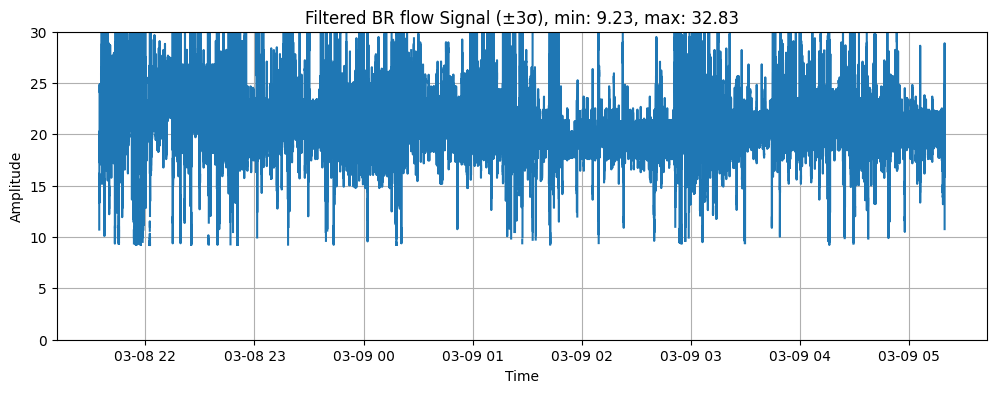

Processing folders:  27%|██▋       | 4/15 [04:06<12:10, 66.39s/it]

Data saved to: data/SL0010_20250308/br_flow_data.csv
Removed 134826 points as outliers (2.42%)
Extracting EDF parameters from /Users/yaelalon/SleepLabProcessing/data/SL0008_20250304/20250304-0008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5608599  =      0.000 ... 28042.995 secs...


Processing folders:  27%|██▋       | 4/15 [04:13<11:37, 63.43s/it]


KeyboardInterrupt: 

In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mne.io import read_raw_edf
from tqdm import tqdm
from datetime import datetime, timedelta
import glob

def process_signal(edf_raw, channel_name, folder_path, std_th=2, y_min=None, y_max=None):
    # Get the data for specified channel
    signal_data = edf_raw.get_data(channel_name)[0]

    # Create dataframe with original data and exact timestamps
    start_time = edf_raw.info['meas_date']
    df = pd.DataFrame({
        'time': [start_time + timedelta(seconds=t) for t in edf_raw.times],
        'original_signal': signal_data
    })

    # Calculate mean and standard deviation
    median = np.median(df['original_signal'])
    mean = np.mean(df['original_signal'])
    std = np.std(df['original_signal'])
    
    # Filter out values exceeding std_th standard deviations from median
    df['filtered_signal'] = df['original_signal'].where(
        abs(df['original_signal'] - mean) <= std_th * std, np.nan)

    # Plot original signal
    plt.figure(figsize=(12, 4))
    plt.plot(df['time'], df['original_signal'], alpha=0.5)
    plt.title(f'Original {channel_name} Signal (median: {median:.2f}, min: {df["original_signal"].min():.2f}, max: {df["original_signal"].max():.2f})')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    if y_min is not None and y_max is not None:
        plt.ylim(y_min, y_max)
    plt.grid(True)
    plt.show()

    # Plot filtered signal
    plt.figure(figsize=(12, 4))
    plt.plot(df['time'], df['filtered_signal'])
    plt.title(f'Filtered {channel_name} Signal (±{std_th}σ), min: {df["filtered_signal"].min():.2f}, max: {df["filtered_signal"].max():.2f}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    if y_min is not None and y_max is not None:
        plt.ylim(y_min, y_max)
    plt.grid(True)
    plt.show()

    # Save original and filtered data to CSV
    df.to_csv(f'{folder_path}/{channel_name.lower().replace(" ","_")}_data.csv', index=False)

    print(f"Data saved to: {folder_path}/{channel_name.lower().replace(' ','_')}_data.csv")
    total_points = len(df['filtered_signal'])
    removed_points = df['filtered_signal'].isna().sum()
    percentage_removed = (removed_points / total_points) * 100
    print(f"Removed {removed_points} points as outliers ({percentage_removed:.2f}%)")

# Iterate over all folders in the data directory
data_dir = 'data'
for folder in tqdm(os.listdir(data_dir), desc="Processing folders"):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):        
        edf_file = glob.glob(os.path.join(folder_path, '*.edf'))
        #edf_file = edf_file[0]
        if len(edf_file) == 0:
            print(f"No edf file found in {folder_path}")
            continue
        
        edf_file = edf_file[0]
        patient = edf_file.split('/')[-2]
        if os.path.exists(edf_file):
            edf_raw = read_raw_edf(edf_file, preload=True)
            process_signal(edf_raw, 'Pulse', folder_path, std_th=3, y_min=0, y_max=110)
            process_signal(edf_raw, 'BR flow', folder_path, std_th=3, y_min=0, y_max=30)



### Evaluate RR and HR accuracy ###

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def fetch_signal_time(db_manager, study):
    query = f"""
    SELECT RadarSignal.SessionID, RadarSignal.SessionSignalID, RadarSignal.StartTime as RadarStartTime from RadarSignal
    JOIN Session ON RadarSignal.SessionID = Session.ID
    JOIN Patient ON Session.PatientID = Patient.ID
    JOIN Study ON Patient.StudyID = Study.ID
    WHERE Study.Name = '{study}'
    """
    return pd.read_sql(query, db_manager.engine)

# Load new device results
study = 'Sleep Lab'
holosis_results = pd.read_csv('data/new_resp_results.csv')
radar_signal_time = fetch_signal_time(db_manager, study)
holosis_results = pd.merge(holosis_results, radar_signal_time, on=['SessionSignalID', 'SessionID'], how='left')
results_with_ref = holosis_results.copy()

def compute_ref_per_signal(data, signal_time):
    data['time'] = pd.to_datetime(data['time'], format='mixed').dt.tz_localize(None) 
    time_diff = (data['time'] - signal_time).abs()
    signal_ind = time_diff.idxmin()
    start_time = data.loc[signal_ind, 'time']
    end_time = start_time + pd.Timedelta(minutes=1)
    interval_data = data[(data['time'] >= start_time) & (data['time'] < end_time)]
    ref_value = interval_data['filtered_signal'].median()
    return ref_value
    
# Iterate over patient+date combinations
for (patient, date, session_id), group in holosis_results.groupby(['PatientStudyName', holosis_results['StartTime'], 'SessionID']):
    session_date = pd.to_datetime(date).strftime('%Y%m%d')
    local_path = f'data/{patient}_{session_date}'
    rr_data = pd.read_csv(f'{local_path}/br_flow_data.csv')
    hr_data = pd.read_csv(f'{local_path}/pulse_data.csv')
    for session_signal_id in group['SessionSignalID']:
        index = results_with_ref[(results_with_ref['SessionSignalID'] == session_signal_id) & \
            (results_with_ref['SessionID'] == session_id)].index[0]
        row = group[group['SessionSignalID'] == session_signal_id]
        signal_time = row['RadarStartTime'].values[0]
        signal_time = pd.to_datetime(row['RadarStartTime'].iloc[0]).tz_localize(None)  # Remove timezone info
        
        hr_ref = compute_ref_per_signal(hr_data, signal_time)
        rr_ref = compute_ref_per_signal(rr_data, signal_time)
        
        results_with_ref.loc[index, 'ReferenceHR'] = hr_ref/60
        results_with_ref.loc[index, 'ReferenceRR'] = rr_ref/60
        results_with_ref.to_csv('data/results_with_ref.csv', index=False)

/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/yaelalon/Library/Caches/pypoetry/virtualenvs/sleeplabprocessing-bAcChQS--py3.12/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/yaela

### Filter artifacts ###

In [24]:
import re
import os
import pandas as pd
from datetime import datetime, timedelta

import pandas as pd
from datetime import datetime, timedelta

# Create a dictionary to store artifact times for each session
artifact_dict = {}
results_with_ref = pd.read_csv('data/results_with_ref.csv')

# Go through all folders in data directory
for folder in os.listdir('data'):
    if os.path.isdir(os.path.join('data', folder)) and '_' in folder:
        # Extract patient and date from folder name
        patient, date = folder.split('_')
        
        # Look for artifact file
        artifact_file = os.path.join('data', folder, date[-8:] + '-' + patient[-4:])
        if os.path.exists(artifact_file):
            with open(artifact_file, 'r') as file:
                lines = file.readlines()
                
            session_artifacts = []
            
            flow_found = False
            for line in lines:
                if 'Events Channel' in line and flow_found:
                    break
                    
                if 'Events Channel' in line and 'Pulse' in line:
                    flow_found = True
                    
                if 'Artifact' in line and flow_found:
                    # Extract start time and duration
                    start_match = re.search(r'Start: (\d{2}:\d{2}:\d{2})', line)
                    duration_match = re.search(r'Duration \[ms\]: (\d+(?:\.\d+)?)', line)
                    
                    if start_match and duration_match:
                        start_time = start_match.group(1)
                        duration = float(duration_match.group(1)) / 1000.0  # Convert ms to seconds
                        
                        # Convert to datetime objects
                        start_dt = datetime.strptime(f"{date} {start_time}", "%Y%m%d %H:%M:%S")
                        end_dt = start_dt + timedelta(seconds=duration)
                        session_artifacts.append((start_dt, end_dt))
            
            artifact_dict[folder] = session_artifacts

# Add HasArtifact column to results_with_ref
results_with_ref['HasArtifact'] = False

# Check each row if it falls within an artifact period
for idx, row in results_with_ref.iterrows():
    patient = row['PatientStudyName']
    signal_time = pd.to_datetime(row['RadarStartTime'])
    signal_end = signal_time + timedelta(seconds=60)  # Signal ends 60 seconds later
    session_date = signal_time.strftime('%Y%m%d')
    folder_name = f"{patient}_{session_date}"
    
    if folder_name in artifact_dict:
        for start_dt, end_dt in artifact_dict[folder_name]:
            # Check if the two time periods overlap
            if max(signal_time, start_dt) <= min(signal_end, end_dt):
                results_with_ref.loc[idx, 'HasArtifact'] = True
                break


# Save updated results
results_with_ref.to_csv('data/results_with_ref.csv', index=False)

## Plot accuracy ##

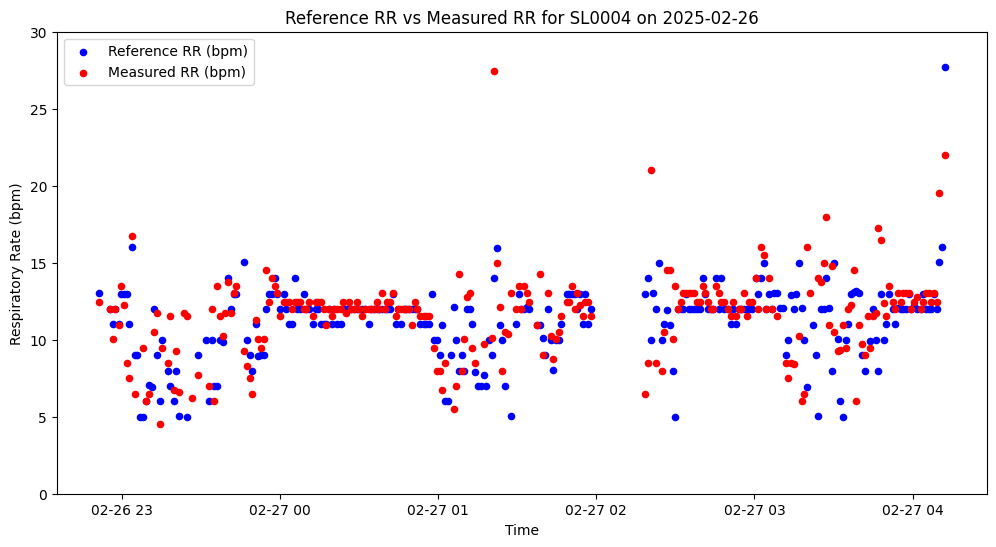

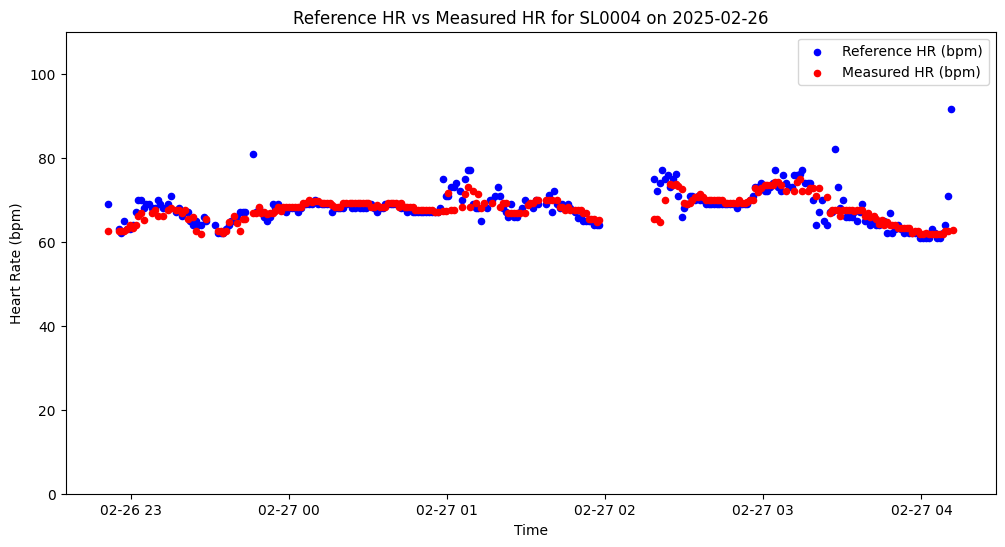

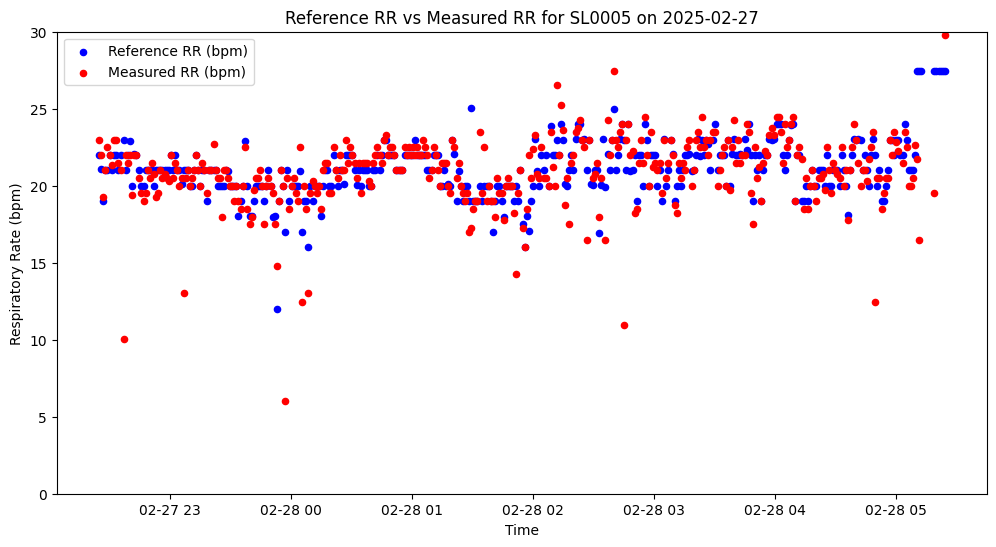

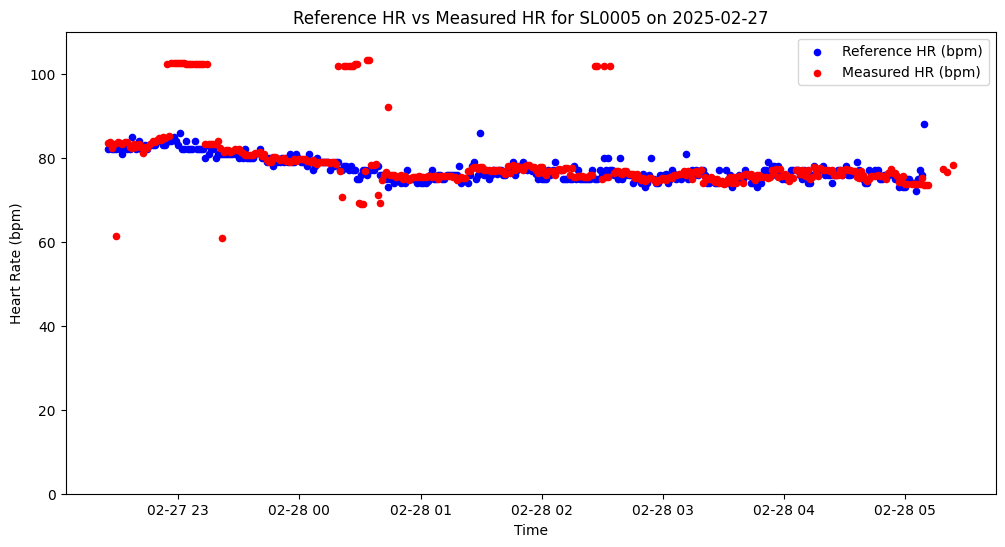

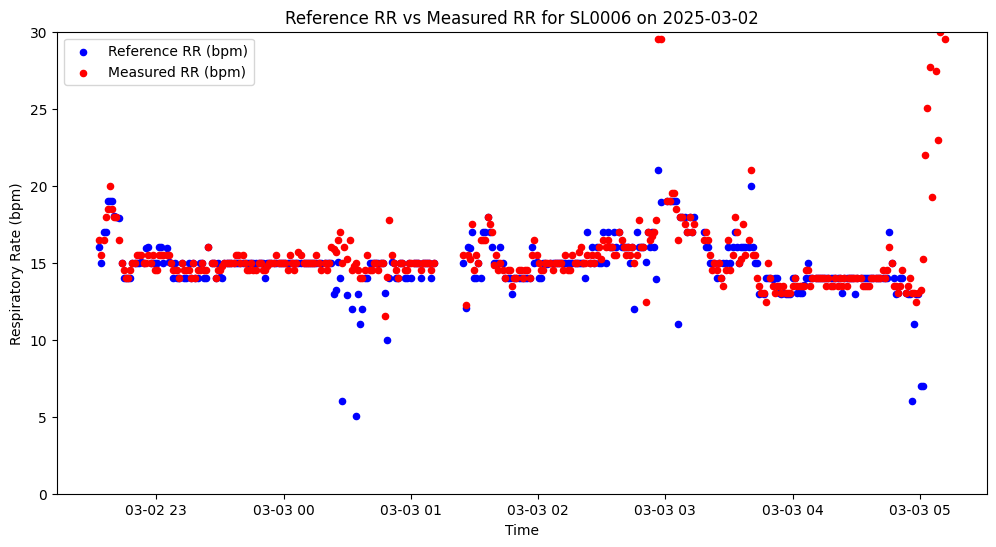

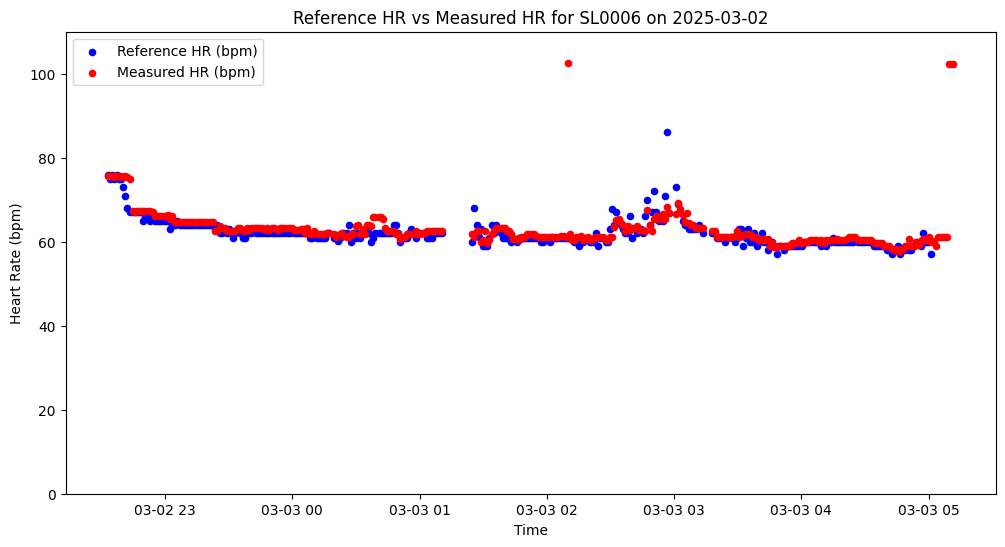

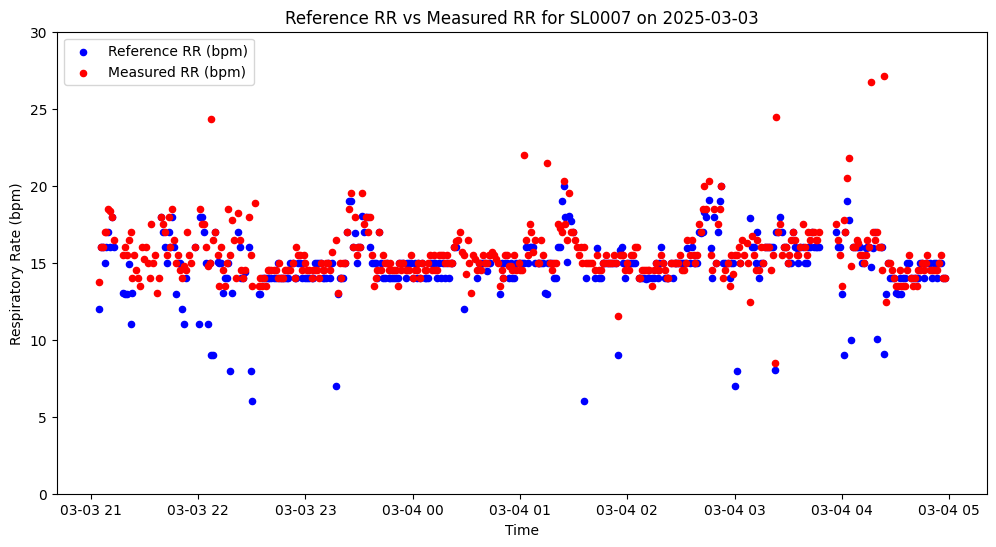

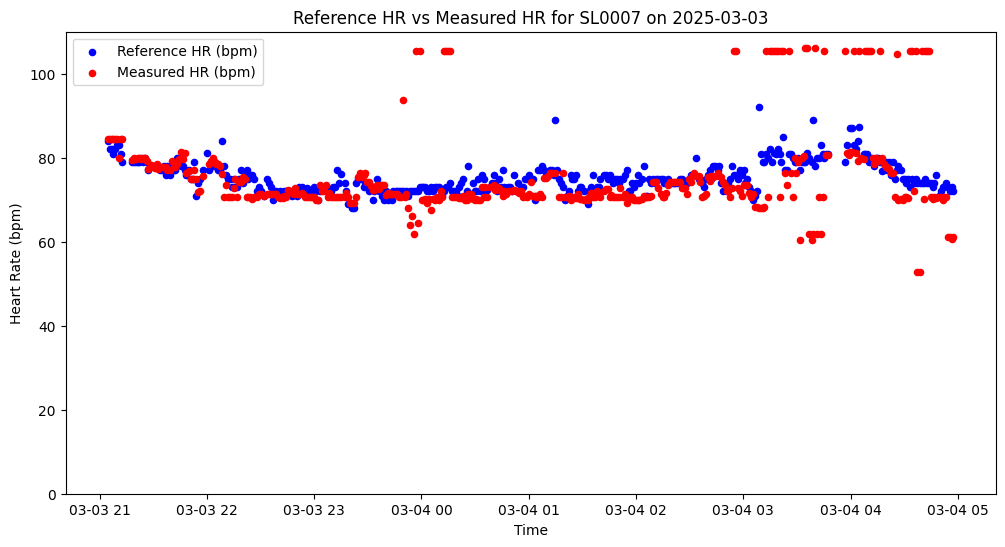

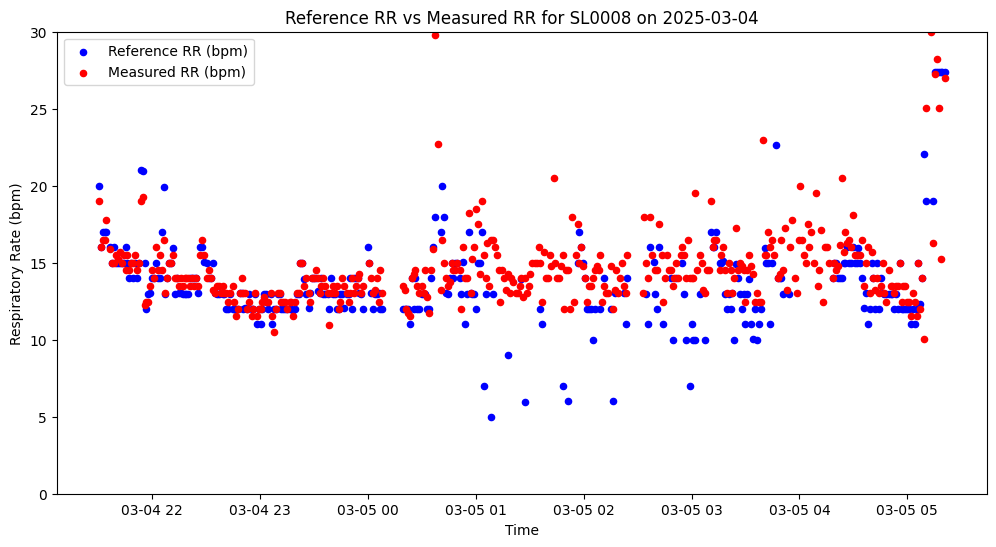

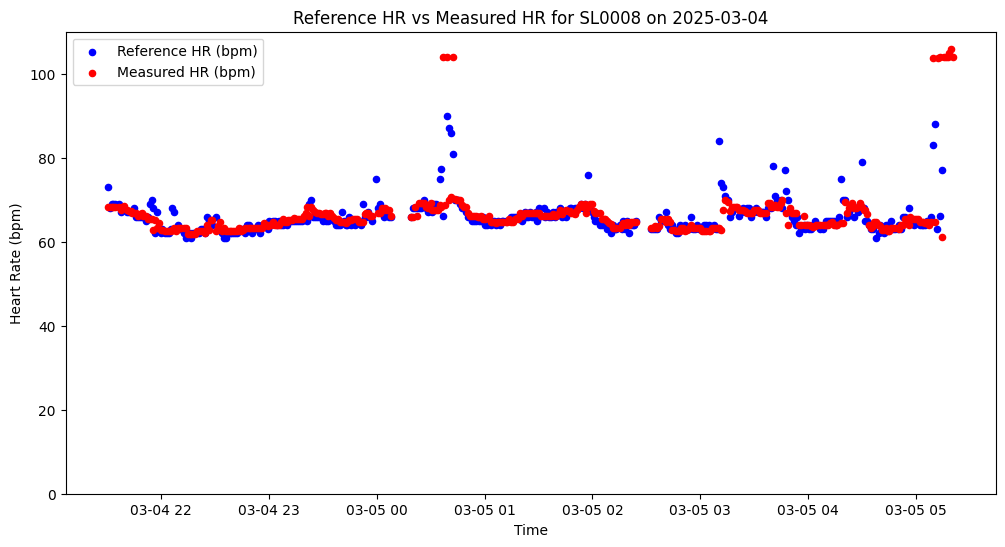

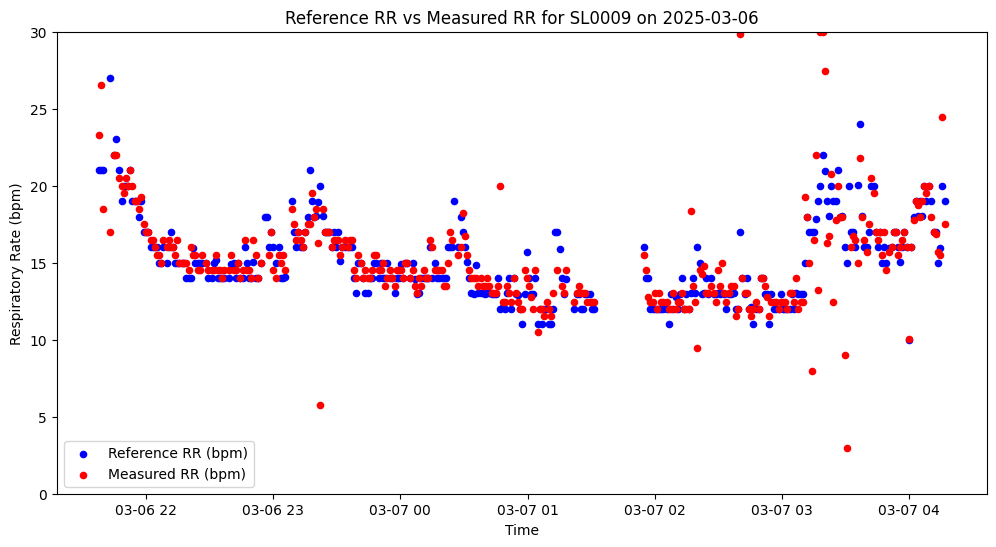

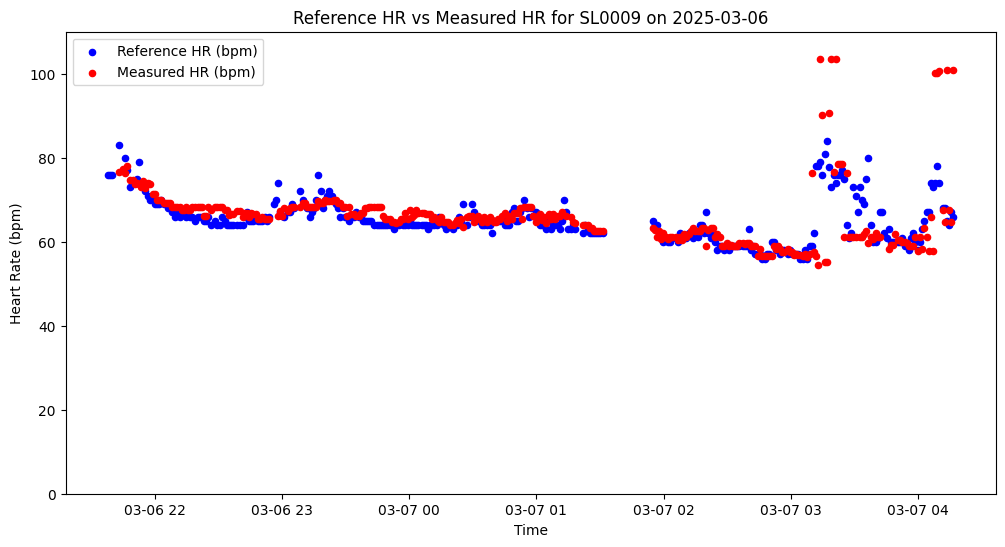

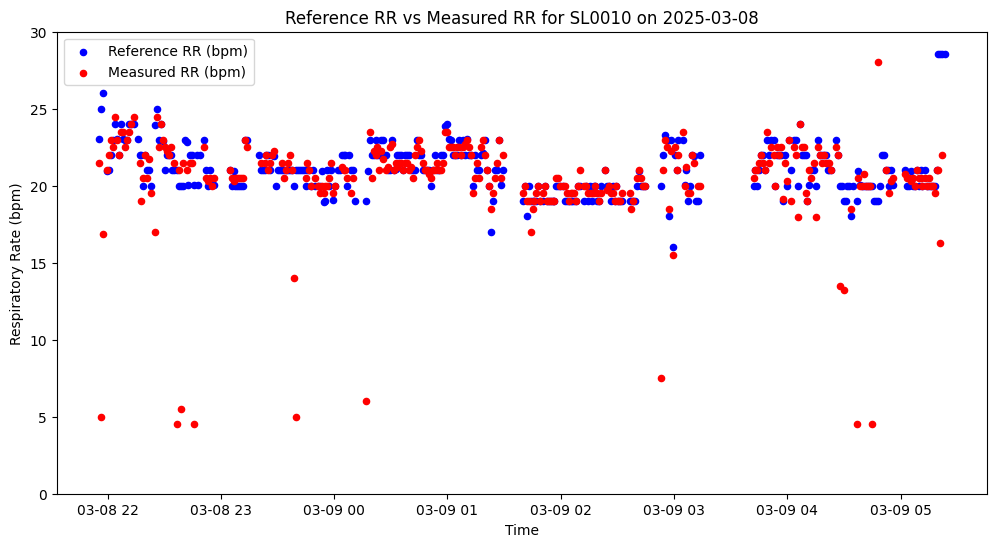

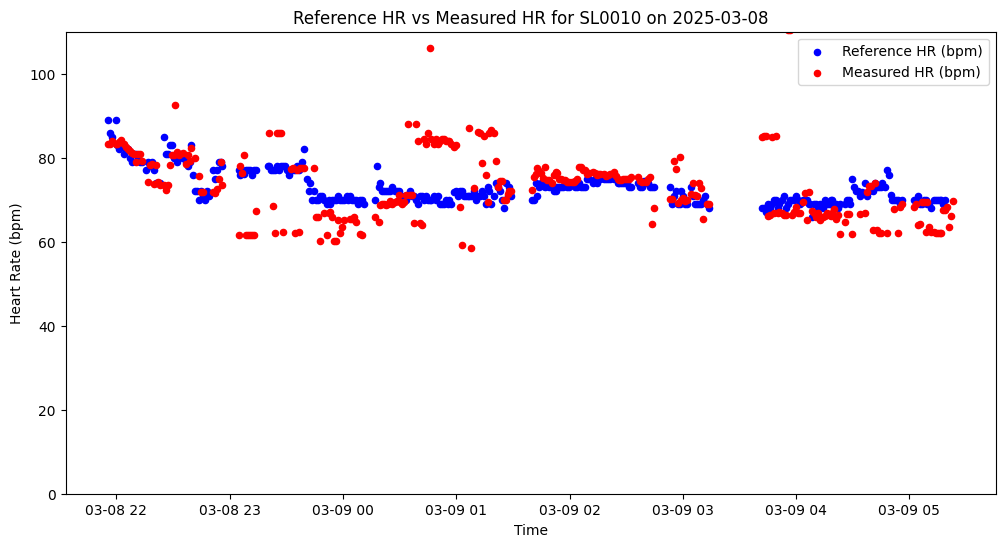

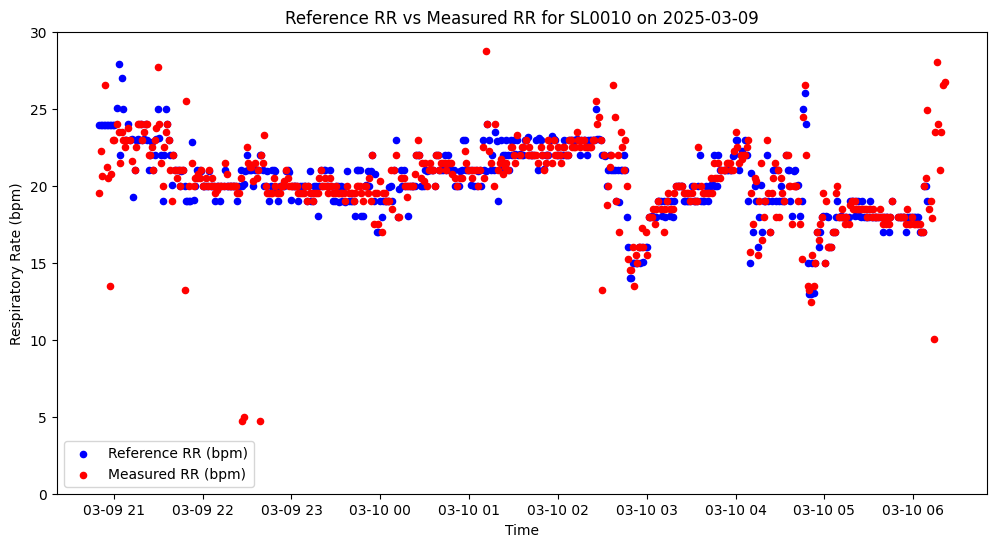

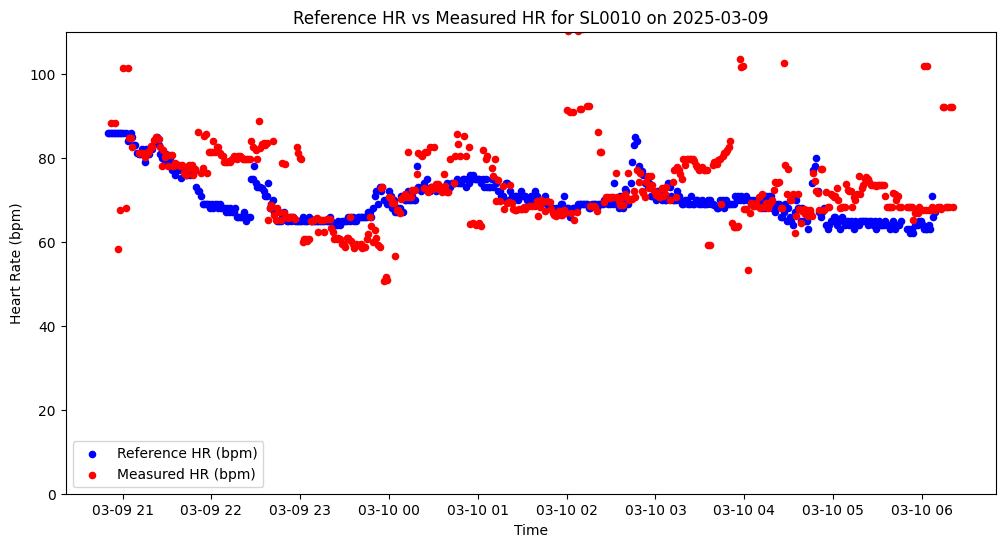

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

results_with_ref = pd.read_csv('data/results_with_ref.csv')
filter_artifacts = True

# Load results_with_ref
results_with_ref = results_with_ref[results_with_ref['HasArtifact'] == False] if filter_artifacts else results_with_ref
# Multiply the results by 60 to get bpm
results_with_ref['ReferenceRR_bpm'] = results_with_ref.apply(lambda x: x['ReferenceRR'] * 60 if x['ReferenceRR'] * 60 > 5 else None, axis=1)
results_with_ref['MeasuredRR_bpm'] = results_with_ref['RespirationRate_new'] * 60
results_with_ref['ReferenceHR_bpm'] = results_with_ref['ReferenceHR'] * 60
results_with_ref['MeasuredHR_bpm'] = results_with_ref['HeartRate_new'] * 60

# Convert 'StartTime' to datetime for plotting
results_with_ref['RadarStartTime'] = pd.to_datetime(results_with_ref['RadarStartTime'])

# Plot separately for every patient + date
for (patient, date), group in results_with_ref.groupby(['PatientStudyName', 'StartTime']):
    group = group.sort_values(by='RadarStartTime')
    date_only = pd.to_datetime(date).date()  # Extract only the date part
    plt.figure(figsize=(12, 6))
    plt.scatter(group['RadarStartTime'], group['ReferenceRR_bpm'], label='Reference RR (bpm)', color='blue', s=20)
    plt.scatter(group['RadarStartTime'], group['MeasuredRR_bpm'], label='Measured RR (bpm)', color='red', s=20)
    plt.xlabel('Time')
    plt.ylim(0, 30)
    plt.ylabel('Respiratory Rate (bpm)')
    plt.title(f'Reference RR vs Measured RR for {patient} on {date_only}')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.scatter(group['RadarStartTime'], group['ReferenceHR_bpm'], label='Reference HR (bpm)', color='blue', s=20)
    plt.scatter(group['RadarStartTime'], group['MeasuredHR_bpm'], label='Measured HR (bpm)', color='red', s=20)
    plt.xlabel('Time')
    plt.ylim(0, 110)
    plt.ylabel('Heart Rate (bpm)')
    plt.title(f'Reference HR vs Measured HR for {patient} on {date_only}')
    plt.legend()
    plt.show()


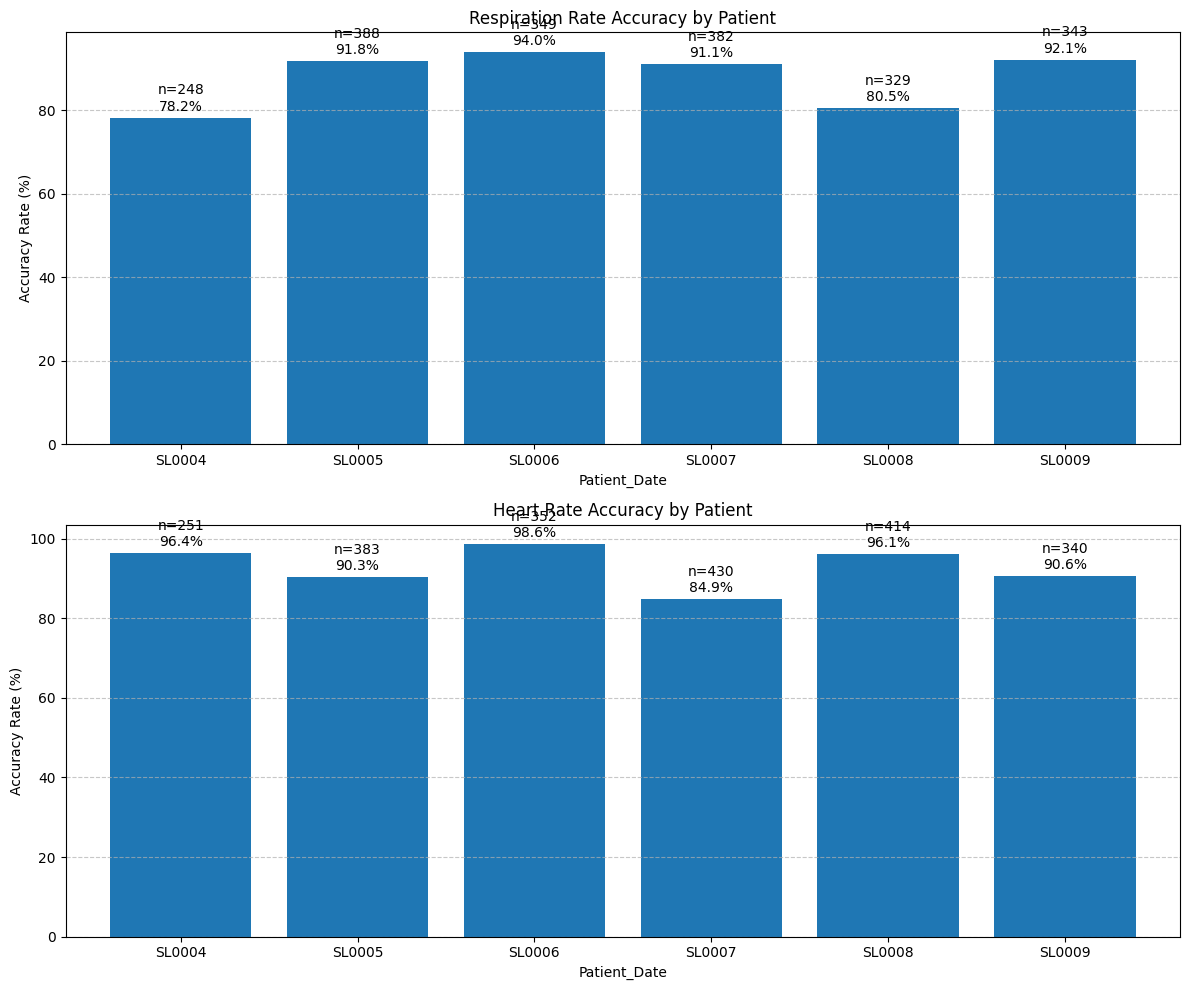

In [53]:
# Define criteria for rr and hr using bpm values, ignoring NaN values
def is_rr_accurate(measured_rr_bpm, reference_rr_bpm):
    if pd.isna(measured_rr_bpm) or pd.isna(reference_rr_bpm):
        return None
    return abs(measured_rr_bpm - reference_rr_bpm) < 2 or abs((measured_rr_bpm - reference_rr_bpm) / reference_rr_bpm) < 0.1

def is_hr_accurate(measured_hr_bpm, reference_hr_bpm):
    if pd.isna(measured_hr_bpm) or pd.isna(reference_hr_bpm):
        return None
    return abs(measured_hr_bpm - reference_hr_bpm) < 5 or abs((measured_hr_bpm - reference_hr_bpm) / reference_hr_bpm) < 0.1

# Function to calculate accuracy rates
def calculate_accuracy_rates(results, measured_rr_col, measured_hr_col, version_suffix):
    accuracy_rates = []
    results[f'MeasuredRR_bpm_{version_suffix}'] = results[measured_rr_col] * 60
    results[f'MeasuredHR_bpm_{version_suffix}'] = results[measured_hr_col] * 60

    for (patient, date), group in results.groupby(['PatientStudyName', 'StartTime']):
        # Filter for detected signals
        rr_detected = group[(group['RespDetected_new'] == True) & (group['ReferenceRR_bpm'] != 0)]
        hr_detected = group[(group['HrDetected_new'] == True) & (group['ReferenceHR_bpm'] != 0)]
        
        # Calculate accuracy for detected signals using bpm values, ignoring NaN values
        rr_accurate = rr_detected.apply(lambda x: is_rr_accurate(x[f'MeasuredRR_bpm_{version_suffix}'], x['ReferenceRR_bpm']), axis=1).dropna()
        hr_accurate = hr_detected.apply(lambda x: is_hr_accurate(x[f'MeasuredHR_bpm_{version_suffix}'], x['ReferenceHR_bpm']), axis=1).dropna()
        
        # Calculate rates
        rates = {
            'Patient': patient,
            'Session Date': date,
            'Patient_Date': f"{patient}\n{date}" if len(results[results['PatientStudyName'] == patient]['StartTime'].unique()) > 1 else patient,
            f'RR Accuracy {version_suffix}': (rr_accurate.sum() / len(rr_accurate) * 100) if len(rr_accurate) > 0 else 0,
            f'HR Accuracy {version_suffix}': (hr_accurate.sum() / len(hr_accurate) * 100) if len(hr_accurate) > 0 else 0,
            f'RR Detected Count {version_suffix}': len(rr_accurate),  # Changed to count non-NA samples
            f'HR Detected Count {version_suffix}': len(hr_accurate)   # Changed to count non-NA samples
        }
        accuracy_rates.append(rates)

    return pd.DataFrame(accuracy_rates)

filter_artifacts = False
results_with_ref = results_with_ref[results_with_ref['HasArtifact'] == False] if filter_artifacts else results_with_ref

# Calculate accuracy for both versions
df_accuracy_v0_1_5 = calculate_accuracy_rates(results_with_ref, 'RespirationRate_new', 'HeartRate_new', 'ver0.1.5')
df_accuracy_v0_1_1 = calculate_accuracy_rates(results_with_ref, 'RespirationRate', 'HeartRate', 'ver0.1.1')

# Merge the dataframes for plotting
df_accuracy = pd.merge(df_accuracy_v0_1_5, df_accuracy_v0_1_1, on=['Patient', 'Session Date', 'Patient_Date'])

def plot_accuracy_comparison(df_accuracy, exclude_patients=None, show_only_new=False):
    # Filter out excluded patients if specified
    plot_df = df_accuracy.copy()
    if exclude_patients:
        plot_df = plot_df[~plot_df['Patient'].isin(exclude_patients)]
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Set up colors and columns based on versions shown
    if show_only_new:
        colors = ['#1f77b4']
        rr_cols = ['RR Accuracy ver0.1.5']
        hr_cols = ['HR Accuracy ver0.1.5']
    else:
        colors = ['#1f77b4', '#ff7f0e']
        rr_cols = ['RR Accuracy ver0.1.1', 'RR Accuracy ver0.1.5']
        hr_cols = ['HR Accuracy ver0.1.1', 'HR Accuracy ver0.1.5']
        legend_labels = ['ver0.1.1', 'ver0.1.5']

    # Plot Respiration Accuracy Rates
    plot_df.plot(x='Patient_Date', y=rr_cols, kind='bar', ax=ax1, width=0.8, color=colors, legend=not show_only_new)
    ax1.set_title('Respiration Rate Accuracy by Patient')
    ax1.set_ylabel('Accuracy Rate (%)')
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    ax1.set_xticklabels(plot_df['Patient_Date'], rotation=0)
    if not show_only_new:
        ax1.legend(legend_labels)

    # Add count labels and percentage on top of bars
    for i in range(len(plot_df)):
        if not show_only_new:
            v2 = plot_df['RR Accuracy ver0.1.1'].iloc[i]
            ax1.text(i - 0.15, v2 + 1, f'n={plot_df["RR Detected Count ver0.1.1"].iloc[i]}\n{v2:.1f}%', 
                     ha='center', va='bottom', color='black')
        v1 = plot_df['RR Accuracy ver0.1.5'].iloc[i]
        offset = 0 if show_only_new else 0.15
        ax1.text(i + offset, v1 + 1, f'n={plot_df["RR Detected Count ver0.1.5"].iloc[i]}\n{v1:.1f}%', 
                 ha='center', va='bottom', color='black')

    # Plot Heart Rate Accuracy Rates
    plot_df.plot(x='Patient_Date', y=hr_cols, kind='bar', ax=ax2, width=0.8, color=colors, legend=not show_only_new)
    ax2.set_title('Heart Rate Accuracy by Patient')
    ax2.set_ylabel('Accuracy Rate (%)')
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    ax2.set_xticklabels(plot_df['Patient_Date'], rotation=0)
    if not show_only_new:
        ax2.legend(legend_labels)

    # Add count labels and percentage on top of bars
    for i in range(len(plot_df)):
        if not show_only_new:
            v2 = plot_df['HR Accuracy ver0.1.1'].iloc[i]
            ax2.text(i - 0.15, v2 + 1, f'n={plot_df["HR Detected Count ver0.1.1"].iloc[i]}\n{v2:.1f}%', 
                     ha='center', va='bottom', color='black')
        v1 = plot_df['HR Accuracy ver0.1.5'].iloc[i]
        offset = 0 if show_only_new else 0.15
        ax2.text(i + offset, v1 + 1, f'n={plot_df["HR Detected Count ver0.1.5"].iloc[i]}\n{v1:.1f}%', 
                 ha='center', va='bottom', color='black')

    plt.tight_layout()
    plt.show()

# Example usage:
plot_accuracy_comparison(df_accuracy, exclude_patients=['SL0010'], show_only_new=True)
plot_accuracy_comparison(df_accuracy, exclude_patients=[], show_only_new=False)

# To exclude patients and show only new version:
# plot_accuracy_comparison(df_accuracy, exclude_patients=['Patient1', 'Patient2'], show_only_new=True)
